# Решение тестового задания с kaggle: 
https://www.kaggle.com/competitions/sbermarket-internship-competition/overview
мой первый сабмит показал результат - Score: 0.45269 (номер 92 в турнирной таблице по всем пользователям (337))
мой второй сабмит показал результат - Score: 0.48208 (номер 52 в турнирной таблице по всем пользователям (363))
(Максимальный результат у 1 места - 0.49851)

Описание задачи: 
Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:

user_id - уникальный id пользователя
order_completed_at - дата заказа
cart - список уникальных категорий (category_id), из которых состоял заказ
В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

Мое решение: 
для решения задачи я буду ипсользовать метод knn tifu (temporal-item-frequency-based-user-KNN)
Knn TIFU - один из методов ближайших соседей, в котором предсказания производят на основе частоты временных рядов
Этот метод был выбран, потому что его рекомендуют для нашего типа задач

In [260]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import DistanceMetric
from sklearn.metrics import f1_score

In [261]:
# анализ данных в наличии 

In [262]:
sample = pd.read_csv('/Users/polina/Downloads/sbermarket-internship-competition/sample_submission.csv')

In [263]:
sample.head(3)

,id,target
0,0;133,0
1,0;5,1
2,0;10,0


In [264]:
# приведем 1 колонку sample в другой вид
df_id = sample['id'].str.split(';', expand=True)
df_id.columns=['user_id', 'cart']
final_sample = pd.concat([sample, df_id], axis=1)
final_sample.head(3)
final_sample = final_sample.drop('target', axis=1)

In [265]:
final_sample.head(3)

,id,user_id,cart
0,0;133,0,133
1,0;5,0,5
2,0;10,0,10


In [266]:
train = pd.read_csv('/Users/polina/Downloads/sbermarket-internship-competition/train.csv')

In [267]:
# посмотрим данные train 
train.head(10)

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
5,2,2015-03-22 09:25:46,82
6,2,2015-03-22 09:25:46,134
7,2,2015-03-22 09:25:46,16
8,2,2015-03-22 09:25:46,409
9,2,2015-03-22 09:25:46,384


In [268]:
# посмотрим размер
train.shape

(3123064, 3)

In [269]:
# посмотрим типы данных
train.dtypes

user_id                int64
order_completed_at    object
cart                   int64
dtype: object

In [270]:
# посмотрим количество пропущенных значений
train.isnull().sum()

user_id               0
order_completed_at    0
cart                  0
dtype: int64

In [271]:
# посмотрим количество уникальных значений
train.nunique()

user_id                20000
order_completed_at    208155
cart                     881
dtype: int64

In [272]:
# пользователи, которые заказывают больше всего товаров
user_pop = pd.DataFrame(train['user_id'].value_counts().reset_index())
user_pop.head(10)

,user_id,count
0,380,3508
1,105,2833
2,84,2610
3,3918,2566
4,1156,2357
5,2196,2296
6,918,2288
7,2711,2286
8,606,2177
9,6102,2164


In [273]:
user_pop.describe()

,user_id,count
count,20000.000000,20000.000000
mean,9999.500000,156.153200
std,5773.647028,200.840781
min,0.000000,3.000000
25%,4999.750000,48.000000
50%,9999.500000,88.000000
75%,14999.250000,181.000000
max,19999.000000,3508.000000


<Axes: xlabel='count', ylabel='Count'>

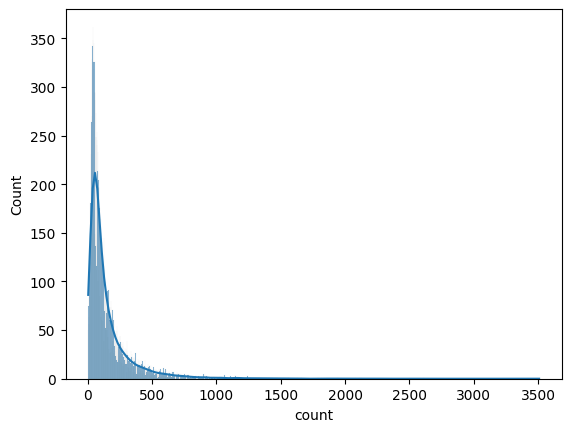

In [274]:
sns.histplot(user_pop['count'], bins=2000, kde=True)

In [275]:
# категории, которые заказывают чаще всего 
cart_pop = pd.DataFrame(train['cart'].value_counts().reset_index())
cart_pop.head(10)

,cart,count
0,57,108877
1,14,93957
2,61,91543
3,398,81694
4,23,71837
5,84,68715
6,22,68478
7,409,59920
8,17,58840
9,402,49925


In [276]:
# вычислим среднее количество категорий, который заказывает каждый пользователь
# найдем количество по каждой дате(заказу)
users_mean_cart = train.groupby(['user_id', 'order_completed_at']).agg({'cart': 'count'}).reset_index()

# найдем среднее количество по каждому пользователю
users_mean_carts_numbers = users_mean_cart.groupby('user_id').agg({'cart': 'median'}).astype('int').reset_index().sort_values('cart', ascending=False)
users_mean_carts_numbers.head(10)

,user_id,cart
13619,13619,79
16550,16550,61
9810,9810,60
5239,5239,60
2727,2727,56
569,569,54
840,840,53
3291,3291,52
14226,14226,52
4763,4763,49


In [277]:
# отсортируем таблицу по user_id, нам это пригодится для предсказания далее
users_mean_carts_numbers = users_mean_carts_numbers.sort_values('user_id')

In [278]:
# для будущих предсказаний нам надо понимать среднюю величину корзины каждого пользователя
users_mean_carts_numbers.describe()

,user_id,cart
count,20000.000000,20000.00000
mean,9999.500000,13.89790
std,5773.647028,6.59014
min,0.000000,1.00000
25%,4999.750000,9.00000
50%,9999.500000,13.00000
75%,14999.250000,17.00000
max,19999.000000,79.00000


In [279]:
# построение предсказания

In [280]:
# преобработаем данные 

In [281]:
# добавим в train колонку sold, в котором отразил факт наличия покупки
train['sold'] = 1

In [282]:
# преобразуем таблицу в необходимый формат, где колонка cart транспонирована в колонки со значением факта наличия покупки
train_carts = train.pivot_table('sold', ['user_id', 'order_completed_at'], 'cart').reset_index()
train_carts = train_carts.fillna(0)
train_carts

cart,user_id,order_completed_at,0,1,2,3,4,5,6,7,...,871,872,873,874,875,876,877,878,879,880
0,0,2020-07-19 09:59:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2020-08-24 08:55:32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2020-09-02 07:38:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2019-05-08 16:09:41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2020-01-17 14:44:23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209401,19998,2020-09-01 08:12:32,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209402,19998,2020-09-02 15:03:23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209403,19999,2020-08-31 18:54:24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209404,19999,2020-08-31 19:32:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
# добавим r, который отражает вектор веса каждого заказа для каждого пользователя от позднего заказа до раннего 
# старые заказы должны иметь меньший вес. Будем умножать вес r на вектор категорий
# r**0 для последнего заказа
# r**1 для предпоследнего и т.д
r = 0.98

# добавим вес заказов по каждому пользователю по убывающей дате
train_carts.insert(loc=2, column='r_order', value=(r ** train_carts.groupby('user_id').cumcount()))

# умножим категории заказов на вес r
train_carts.iloc[:, 3:] = train_carts.iloc[:, 3:].multiply(train_carts['r_order'], axis='index')

# получаем вес категории для каждого пользователя
train_carts = train_carts.drop(columns=['order_completed_at']).groupby('user_id').sum()

# находим среднее арифметическое взвешенное
train_carts.iloc[:, 1:] = train_carts.iloc[:, 1:].divide(train_carts['r_order'], axis='index')

train_carts

cart,r_order,0,1,2,3,4,5,6,7,8,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,2.940400,0.000000,0.0,0.0,0.0,0.0,0.333288,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.312612,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.071545,0.072003,0.0,0.0,0.0,0.0,0.142566,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.593723,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.461849,0.000000,0.0,0.0,0.0,0.0,0.254946,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.940400,0.333288,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,2.940400,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,2.940400,0.333288,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
# создаем матрицу с векторами user_vector_representation для каждого пользователя, отсортирована по user_id
matrix = train_carts.iloc[:, 1:].to_numpy()
matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07200312, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33328799, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [285]:
# находим вектора соседей

# сначала сделаем модель для поиска ближайших соседей
n_neighbors = 50
model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
model.fit(matrix)

NearestNeighbors(metric='euclidean', n_neighbors=50)

In [286]:
# добавим параметр a - параметр для баланса двух частей: 
# 1. компонент повторяющихся покупок и 2. компонента совместных покупок
a = 0.7

In [287]:
# выведем количество уникальных пользователей и категорий
users_count = 20000
carts_count = 881

In [288]:
# найдем вектора через формулу для knn tifu
result = np.empty([users_count, carts_count])

for i, user_vector in enumerate(matrix):
    # идея для улучшения: использовать веса для соседей в зависимости от их близости
    neighbors = model.kneighbors([matrix[i]], return_distance=False)
    # убираем самого пользователя из соседей
    n_indexes = neighbors[0][1:]

    n_vectors = []
    for n_idx in n_indexes:
        n_vector = matrix[n_idx]
        n_vectors.append(n_vector)

    # пока будем брать среднее векторов соседей
    n_avg = np.average(n_vectors, axis=0)

    # P = α · ut + (1 − α) · un,
    p = a * user_vector + (1 - a) * n_avg
    result[i] = p

result

array([[1.46162939e-02, 1.03090742e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.19246633e-03, 1.91786404e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.60451202e-02, 2.48484291e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.52764607e-01, 2.96568827e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.38048772e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32059920e-02, 8.95569299e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [289]:
# посмотрим на наши результаты
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
0,0.014616,0.000103,0.0,0.0,0.000499,0.272900,0.005108,0.000000,0.000000,0.022662,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004192,0.000192,0.0,0.0,0.000000,0.003672,0.000000,0.000000,0.000000,0.005251,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.076045,0.000248,0.0,0.0,0.000800,0.129241,0.006110,0.000000,0.000354,0.077542,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.017178,0.001148,0.0,0.0,0.000230,0.026391,0.002248,0.000000,0.000000,0.017833,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.022992,0.000000,0.0,0.0,0.000174,0.211444,0.003917,0.000157,0.000000,0.026309,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.268766,0.000896,0.0,0.0,0.000000,0.009854,0.000852,0.000000,0.000000,0.008274,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.016013,0.001180,0.0,0.0,0.000000,0.018932,0.001429,0.000000,0.000000,0.013469,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.252765,0.000297,0.0,0.0,0.000000,0.025046,0.004305,0.000232,0.000000,0.020560,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.013805,0.000000,0.0,0.0,0.000000,0.024889,0.478355,0.000000,0.000194,0.018263,...,0.0,0.0,0.000432,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [290]:
# соединим в одну таблицу среднее количество корзинок и результат предсказания
user_mean_carts_result = users_mean_carts_numbers.merge(pd.DataFrame(result), left_index=True, right_index=True)
user_mean_carts_result = user_mean_carts_result.set_index('user_id')
user_mean_carts_result

,cart,0,1,2,3,4,5,6,7,8,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,11,0.014616,0.000103,0.0,0.0,0.000499,0.272900,0.005108,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0.004192,0.000192,0.0,0.0,0.000000,0.003672,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,0.076045,0.000248,0.0,0.0,0.000800,0.129241,0.006110,0.000000,0.000354,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.017178,0.001148,0.0,0.0,0.000230,0.026391,0.002248,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,0.022992,0.000000,0.0,0.0,0.000174,0.211444,0.003917,0.000157,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,0.268766,0.000896,0.0,0.0,0.000000,0.009854,0.000852,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,5,0.016013,0.001180,0.0,0.0,0.000000,0.018932,0.001429,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,17,0.252765,0.000297,0.0,0.0,0.000000,0.025046,0.004305,0.000232,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [291]:
# для каждого пользователя найдем категории, в количестве среднее число корзинок + 2
result_carts = []
for i in range(20000):
    result_carts.append(user_mean_carts_result.iloc[i].nlargest(user_mean_carts_result['cart'][i]+2))

table_1 = pd.DataFrame(result_carts)

In [292]:
# отсортируем колонки по возрастанию и вернем user_id
table_tops = table_1[sorted(table_1.drop('cart', axis=1).columns)]
table_tops = table_tops.reset_index()

In [293]:
# преобразовываем таблицу в обратный формат столбцов: user_id, cart + 1 колонка target (1, 0 - наше предсказание)
result_tops_train_format = pd.melt(table_tops, id_vars=['index']).sort_values(['index', 'variable'])
result_tops_train_format = result_tops_train_format.rename(columns={'index': 'user_id', 'variable': 'cart', 'value': 'target'})
result_tops_train_format['target'] = result_tops_train_format['target'].apply(lambda x: 1 if x > 0 else 0)
result_tops_train_format = result_tops_train_format.astype('int')
result_tops_train_format

,user_id,cart,target
0,0,0,0
20000,0,1,0
40000,0,5,0
60000,0,6,0
80000,0,9,0
...,...,...,...
8599999,19999,844,0
8619999,19999,846,0
8639999,19999,847,0
8659999,19999,848,0


In [294]:
# меняем тип колонок final_sample для merge его с нашим результатом
final_sample['cart'] = final_sample['cart'].astype('int')
final_sample['user_id'] = final_sample['user_id'].astype('int')

In [295]:
# готовим наш ответ 
submission = final_sample.merge(result_top_20_train_format, on=['user_id', 'cart'], how='left')[['id', 'target']]

submission = submission.fillna(0)

submission['target'] = submission['target'].astype('int')

submission = submission.set_index('id')

In [296]:
submission.to_csv('submission.csv')

# train test работы метода 

In [297]:
# проверим работу нашего метода

In [298]:
# создадим таблицу со всеми категориями
carts = pd.DataFrame(train['cart'].unique())
carts = carts.rename(columns={0: 'cart'})
carts

,cart
0,399
1,14
2,198
3,88
4,157
...,...
876,789
877,752
878,325
879,332


In [299]:
# создадим таблицу со всеми пользователями
users = pd.DataFrame(train['user_id'].unique())
users = users.rename(columns={0: 'user_id'})
users

,user_id
0,2
1,3
2,4
3,5
4,6
...,...
19995,19998
19996,14743
19997,258
19998,19999


In [300]:
# создадим таблицу все пользователи - все категории
users_carts = users.merge(carts, how='cross')
users_carts = users_carts.rename(columns={0: 'cart'})
users_carts

,user_id,cart
0,2,399
1,2,14
2,2,198
3,2,88
4,2,157
...,...,...
17619995,16887,789
17619996,16887,752
17619997,16887,325
17619998,16887,332


In [301]:
# создадим таблицу все пользователи - все категории - все даты
all_users_carts_dates = users_carts.merge(train, how='left')
all_users_carts_dates = all_users_carts_dates.fillna(0)
all_users_carts_dates.sort_values('user_id')

,user_id,cart,order_completed_at,sold
18320739,0,74,0,0.0
18320598,0,53,0,0.0
18320597,0,302,0,0.0
18320596,0,71,0,0.0
18320595,0,271,0,0.0
...,...,...,...,...
19624279,19999,503,0,0.0
19624278,19999,527,0,0.0
19624277,19999,519,0,0.0
19624288,19999,587,0,0.0


In [302]:
# добавим колонку sold - она отражает была ли покупка или нет в завивимости от того, есть ли в order_completed_at дата или нет
all_users_carts_dates['sold'] = 0
all_users_carts_dates['sold'] = all_users_carts_dates['order_completed_at'].apply(lambda x: 0 if x == 0 else 1)
all_users_carts_dates

,user_id,cart,order_completed_at,sold
0,2,399,2015-03-22 09:25:46,1
1,2,14,2015-03-22 09:25:46,1
2,2,198,2015-03-22 09:25:46,1
3,2,198,2018-01-12 23:36:19,1
4,2,88,2015-03-22 09:25:46,1
...,...,...,...,...
19625459,16887,789,0,0
19625460,16887,752,0,0
19625461,16887,325,2020-09-01 09:02:54,1
19625462,16887,332,0,0


In [303]:
# найдем покупки пользователя по каждой категории на последнюю дату
last_order_date_and_cart_for_users = train.groupby(['user_id', 'cart'], as_index=False).agg({'order_completed_at': 'max'})
# также добавим факт наличия покупки 
last_order_date_and_cart_for_users['sold'] = 1

last_order_date_and_cart_for_users

,user_id,cart,order_completed_at,sold
0,0,5,2020-08-24 08:55:32,1
1,0,10,2020-08-24 08:55:32,1
2,0,14,2020-08-24 08:55:32,1
3,0,20,2020-07-19 09:59:17,1
4,0,22,2020-08-24 08:55:32,1
...,...,...,...,...
1117595,19998,409,2020-09-02 15:03:23,1
1117596,19998,415,2020-09-01 08:12:32,1
1117597,19998,420,2020-09-01 08:12:32,1
1117598,19998,798,2020-09-02 15:03:23,1


In [304]:
# создадим таблицу с категориями, которые каждый юзер никогда не взял
never_order_date_and_cart_for_users = all_users_carts_dates[all_users_carts_dates['order_completed_at']==0]
never_order_date_and_cart_for_users

,user_id,cart,order_completed_at,sold
56,2,423,0,0
57,2,92,0,0
60,2,386,0,0
61,2,440,0,0
62,2,389,0,0
...,...,...,...,...
19625458,16887,864,0,0
19625459,16887,789,0,0
19625460,16887,752,0,0
19625462,16887,332,0,0


In [305]:
# это будет наша тестовая выборка - последний заказ + ниразу не заказанный заказ
test_train = pd.concat([last_order_date_and_cart_for_users, never_order_date_and_cart_for_users])

In [306]:
test_train

,user_id,cart,order_completed_at,sold
0,0,5,2020-08-24 08:55:32,1
1,0,10,2020-08-24 08:55:32,1
2,0,14,2020-08-24 08:55:32,1
3,0,20,2020-07-19 09:59:17,1
4,0,22,2020-08-24 08:55:32,1
...,...,...,...,...
19625458,16887,864,0,0
19625459,16887,789,0,0
19625460,16887,752,0,0
19625462,16887,332,0,0


In [307]:
# создадим таблицу для обучения: из полной таблицы удаляем строки с последней датой
train_train  = pd.concat([all_users_carts_dates, last_order_date_and_cart_for_users]).drop_duplicates(subset=['user_id', 'cart', 'order_completed_at'], keep=False)
train_train

,user_id,cart,order_completed_at,sold
2,2,198,2015-03-22 09:25:46,1
4,2,88,2015-03-22 09:25:46,1
6,2,157,2015-03-22 09:25:46,1
8,2,82,2015-03-22 09:25:46,1
9,2,82,2019-10-03 17:37:23,1
...,...,...,...,...
19625458,16887,864,0,0
19625459,16887,789,0,0
19625460,16887,752,0,0
19625462,16887,332,0,0


In [308]:
# далее делаем предсказание по модели как ранее 

In [309]:
train_last_order = train_train.pivot_table('sold', ['user_id', 'order_completed_at'], 'cart').reset_index()
train_last_order = train_last_order.fillna(0)
train_last_order

cart,user_id,order_completed_at,0,1,2,3,4,5,6,7,...,871,872,873,874,875,876,877,878,879,880
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2020-07-19 09:59:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2020-08-24 08:55:32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2019-05-08 16:09:41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205368,19998,2020-08-30 12:15:55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205369,19998,2020-09-01 08:12:32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205370,19999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205371,19999,2020-08-31 18:54:24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
r = 0.98

train_last_order.insert(loc=2, column='r_order', value=(r ** train_last_order.groupby('user_id').cumcount()))
train_last_order.iloc[:, 3:] = train_last_order.iloc[:, 3:].multiply(train_last_order['r_order'], axis='index')
train_last_order = train_last_order.drop(columns=['order_completed_at']).groupby('user_id').sum()
train_last_order.iloc[:, 1:] = train_last_order.iloc[:, 1:].divide(train_last_order['r_order'], axis='index')
train_last_order

cart,r_order,0,1,2,3,4,5,6,7,8,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,2.940400,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.312612,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.071545,0.0,0.0,0.0,0.0,0.0,0.070563,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.803960,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.461849,0.0,0.0,0.0,0.0,0.0,0.128708,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,1.980000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [311]:
matrix = train_last_order.iloc[:, 1:].to_numpy()
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [312]:
n_neighbors = 100

model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
model.fit(matrix)

NearestNeighbors(metric='euclidean', n_neighbors=100)

In [313]:
carts_count = 881

In [314]:
a = 0.7

In [315]:
result = np.empty([users_count, carts_count])
for i, user_vector in enumerate(matrix):
    neighbors = model.kneighbors([matrix[i]], return_distance=False)
    n_indexes = neighbors[0][1:]

    n_vectors = []
    for n_idx in n_indexes:
        n_vector = matrix[n_idx]
        n_vectors.append(n_vector)

    n_avg = np.median(n_vectors, axis=0)

    # P = α · ut + (1 − α) · un,
    p = a * user_vector + (1 - a) * n_avg
    result[i] = p

result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [316]:
# соединим в одну таблицу среднее количество корзинок и результат предсказания
user_mean_carts_result = users_mean_carts_numbers.merge(pd.DataFrame(result), left_index=True, right_index=True)
user_mean_carts_result = user_mean_carts_result.set_index('user_id')
user_mean_carts_result

,cart,0,1,2,3,4,5,6,7,8,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,0.0,0.0,0.0,0.0,0.0,0.049394,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,0.0,0.0,0.0,0.0,0.0,0.090096,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,17,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
# для каждого пользователя найдем категории, в количестве среднее число корзинок + 2
result_carts = []
for i in range(20000):
    result_carts.append(user_mean_carts_result.iloc[i].nlargest(user_mean_carts_result['cart'][i]+2))

table_1 = pd.DataFrame(result_carts)

In [318]:
table_1

,cart,57,14,82,379,405,441,84,0,1,...,330,234,453,650,761,174,746,120,657,780
0,11.0,0.610422,0.233302,0.233302,0.233302,0.233302,0.233302,0.228636,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,0.149314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,0.581093,NaN,0.286085,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.369532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.0,0.597957,NaN,NaN,NaN,NaN,NaN,0.329652,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,17.0,0.446451,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,7.0,0.331288,NaN,NaN,NaN,NaN,NaN,0.228636,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [319]:
# отсортируем колонки по возрастанию и вернем user_id
table_tops = table_1[sorted(table_1.drop('cart', axis=1).columns)]
table_tops = table_tops.reset_index()

In [320]:
# преобразовываем таблицу в обратный формат столбцов: user_id, cart + 1 колонка target (1, 0 - наше предсказание)
result_tops_train_format = pd.melt(table_tops, id_vars=['index']).sort_values(['index', 'variable'])
result_tops_train_format = result_tops_train_format.rename(columns={'index': 'user_id', 'variable': 'cart', 'value': 'target'})
result_tops_train_format['target'] = result_tops_train_format['target'].apply(lambda x: 1 if x > 0 else 0)
result_tops_train_format = result_tops_train_format.astype('int')
result_tops_train_format

,user_id,cart,target
0,0,0,0
20000,0,1,0
40000,0,2,0
60000,0,3,0
80000,0,4,0
...,...,...,...
8939999,19999,846,0
8959999,19999,847,0
8979999,19999,848,0
8999999,19999,853,0


In [321]:
# создаем таблицу с результатом, который был реально, и нашим предсказанным
predict = result_tops_train_format.merge(test_train, on=['user_id', 'cart'])
predict

,user_id,cart,target,order_completed_at,sold
0,0,0,0,0,0
1,0,1,0,0,0
2,0,2,0,0,0
3,0,3,0,0,0
4,0,4,0,0,0
...,...,...,...,...,...
9019995,19999,846,0,0,0
9019996,19999,847,0,0,0
9019997,19999,848,0,0,0
9019998,19999,853,0,0,0


In [322]:
# смотрим на f1 метрику нашего предсказания

In [323]:
round(f1_score(predict['target'], predict['sold']), 5) 
# 0.39015

0.39015